# ML lab 02 - Polynomial regression

---

In [1]:
# Uncomment to upgrade packages
#!pip3 install pandas --upgrade --user --quiet
#!pip3 install numpy --upgrade --user --quiet 
#!pip3 install scipy --upgrade --user --quiet
#!pip3 install statsmodels --upgrade --user --quiet 
#!pip3 install scikit-learn --upgrade --user --quiet
%load_ext autoreload

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import style
import seaborn as sns

In [2]:
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)

In [3]:
# extra imports
from numpy.random import uniform, normal
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [4]:
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

Fix the random number generator so the experiment is reproducible

In [5]:
np.random.seed(7)

We will approximate the function $cos(3\pi x)$ using polynomials

In [7]:
def feval(x):
    return np.cos(3*np.pi*x)

def fgen(N, sigma):
    x = np.sort(uniform(0, 1, N))
    t = feval(x) + normal(loc=0, scale=sigma, size=N)  
    return x,t

## Generate training dataset..

We start generating a sample of 30 examples generating the data assuming that has gaussian noise $N(0,0.25^2)$

In [8]:
N = 30
sigma = 0.25

In [9]:
x,t = fgen(N, sigma)
sample = pd.DataFrame({'input':x,'target':t})

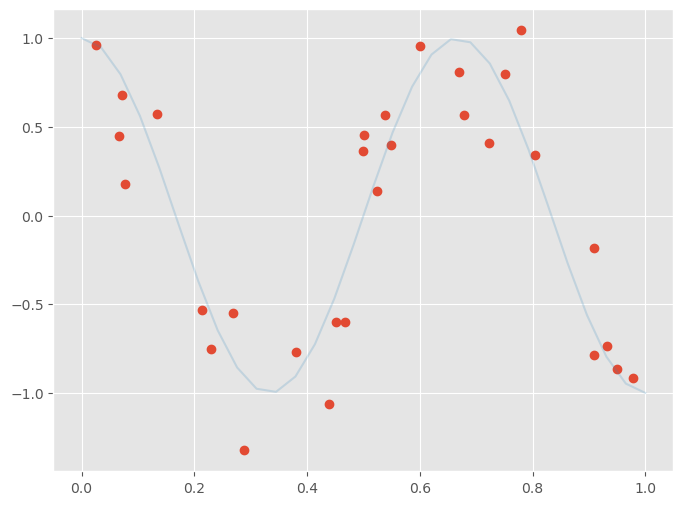

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(sample.input, sample.target, 'o')
ax.plot(np.linspace(0, 1, num=30), feval(np.linspace(0, 1,num=30)), alpha=0.2);

## Generate validation set

We generate also a validation set to evaluate the error with __unseen__ data

In [11]:
N_valid = 1000
x_valid, t_valid = fgen(N_valid, sigma)
valid_sample =  pd.DataFrame({'input':x_valid,'target':t_valid})

## Linear regression via `scikit-learn`'s [`LinearRegression` function](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), sanity check

In the following code, we are going to be doing linear regression with the help of `scikit-learn`. However, just to make sure what this function is doing, let us compare with what we learned in class.

In class, we found that the solution to linear regression via _least squares_ is given by:

$$
\mathbf{\theta}_{lse} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}
$$

In this simple demo, $\mathbf{X}$ is a 30 $\times$ 1 matrix (univariate regression problem), and $\mathbf{y}$ is a column vector of size 30.

In [12]:
X = sample.input.to_numpy().reshape(N, 1)
y = sample.target.to_numpy()

print(f'X has shape {X.shape}, y has shape {y.shape}')

X has shape (30, 1), y has shape (30,)


As we discussed in class, let's add a "fake" first column with all 1 to $\mathbf{X}$.

In [13]:
attr0 = np.ones((N,1))

X = np.hstack((attr0, X))

print(f'X has shape {X.shape}, y has shape {y.shape}')

X has shape (30, 2), y has shape (30,)


check coefficients are the same with both methods..

In [14]:
# solution with slide's formula

lse_coeff = np.linalg.inv(X.T @ X) @ X.T @ y


# solution with SVD formula

U, d, Vt = np.linalg.svd(X, full_matrices=False)
D = np.diag(1/d)
svd_coeff = Vt.T @ D @ U.T @ y


# solution with scikit-learn's LinearRegression function

skl_model = LinearRegression().fit(sample.input.to_numpy().reshape(-1, 1), sample.target)
skl_coeff = [skl_model.intercept_, skl_model.coef_[0]]

# compare solutions

print(lse_coeff)
print(svd_coeff)
print(skl_coeff)

print(f'All solutions are the same: {np.allclose(lse_coeff, svd_coeff)}, {np.allclose(lse_coeff, skl_coeff)}')

[ 0.15186362 -0.2950567 ]
[ 0.15186362 -0.2950567 ]
[0.15186362160168945, -0.2950567016956153]
All solutions are the same: True, True


Now that we have checked that `LinearRegression` works as expected, we can proceed with polynomial regression.

## Fit polynomials for a range of degrees, no regularization

To fit each polynomial, the code uses `LinearRegression` from the library `scikit-learn`. The polynomial fit is done by first doing a _polynomial expansion_ on the inputs with the help of `numpy`'s [Vandermonde's geometric power progression](https://numpy.org/doc/stable/reference/generated/numpy.vander.html), and then applying linear regression on the expanded input.

In [15]:
p = 1                   # smallest degree to try
q = 26                  # largest degree to try  (minus 1, see code below)

coef = []               # holds coefficients of trained polynomials from degree p=1 up to q=26
model = []              # holds trained polynomials from degree p=1 up to q=26
norm_mse_train = []     # holds training error for trained polynomials from degree p=1 up to q=26
norm_mse_valid = []     # holds validation error for trained polynomials from degree p=1 up to q=26

for i in range(p, q):
    cmodel = LinearRegression()
    cmodel.fit(np.vander(sample.input, i+1, increasing=True), sample.target)
    coef.append(cmodel.coef_)
    
    # compute training error as mse on training data
    predictions = cmodel.predict(np.vander(sample.input, i+1, increasing=True))  
    norm_mse_train.append(mean_squared_error(predictions, sample.target))
    
    # compute validation error as mse on validation data
    pred_val = cmodel.predict(np.vander(valid_sample.input, i+1, increasing=True))  
    norm_mse_valid.append(mean_squared_error(pred_val, valid_sample.target))
    
    model.append(cmodel)
0;

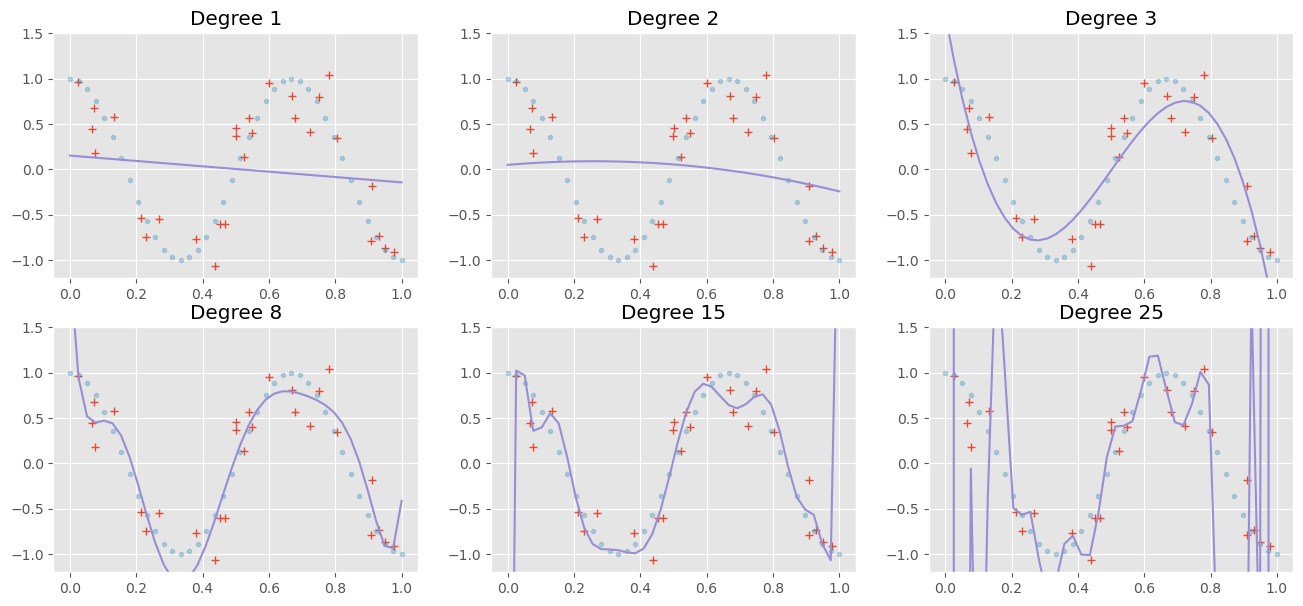

In [16]:
fig = plt.figure(figsize=(16,7))

for f, i in enumerate([1,2,3,8,15,25]):
    ax = fig.add_subplot(2,3,f+1)
    ax.plot(sample.input, sample.target, '+')
    ax.plot(np.linspace(0, 1,num=40), feval(np.linspace(0, 1,num=40)), '.', alpha = 0.3);
    ax.plot(np.linspace(0, 1,num=40), model[i-1].predict(np.vander(np.linspace(0, 1,num=40), i+1, increasing=True)));
    plt.ylim(-1.2,1.5)
    plt.title(f'Degree {i}')
0;

### Plot training/validation error curves

This is the difference among the train and validation data.
_Notice the logarithmic scale_

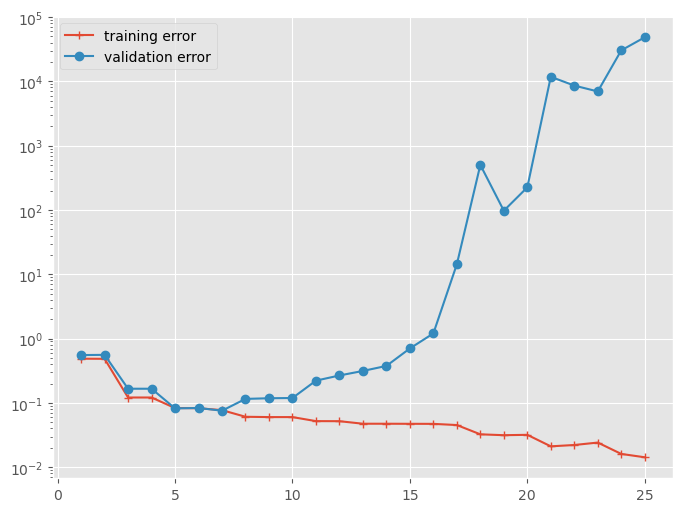

In [17]:
maxdeg = 25
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1, maxdeg+1), norm_mse_train[0:maxdeg], '-+', label='training error')
plt.plot(range(1, maxdeg+1), norm_mse_valid[0:maxdeg], '-o', label='validation error')
plt.yscale('log')
plt.legend();

### Plot coefficients' average magnitudes as a fn. of degree

These are the means of the abssolute value of the coefficients fitted for each polynomial in logarithmic scale. The magnitude of the coefficients gives an idea of the __complexity__ of the fitted model. _Notice the logarithmic scale_

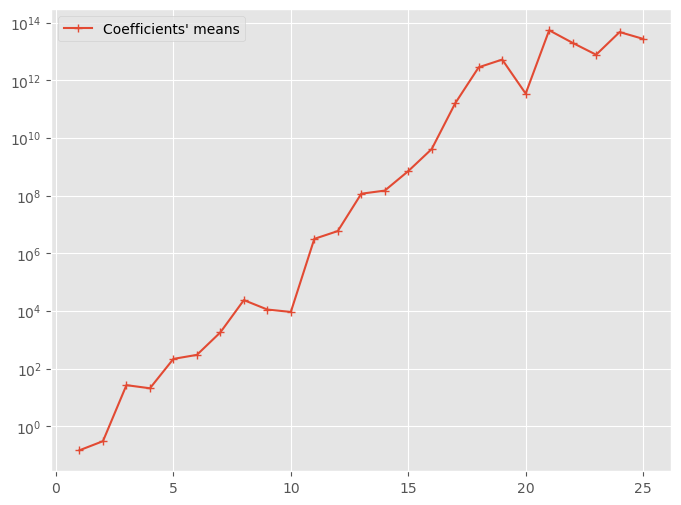

In [18]:
maxdeg = 25
means = [np.mean(np.abs(m.coef_)) for m in model]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1, maxdeg+1), means[0:maxdeg], '-+', label = "Coefficients' means")
plt.yscale('log')
plt.legend();

## Fit polynomials, with regularization

Now we repeat the same but using __regularization__; we first find the best regularization parameter using cross validation.
This is done directly using `scikit-learn`'s [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

In [19]:
p = 1
q = 26

coef = []
model = []
norm_mse_train = []
norm_mse_valid = []


rlambda = np.linspace(0.001, 0.5, num=50)    # these are the values that we will try for regularization parameter lambda

for i in range(p,q):
    cmodel = RidgeCV(alphas=rlambda, scoring=make_scorer(mean_squared_error, greater_is_better=False))
    cmodel.fit(np.vander(sample.input,i+1, increasing=True), sample.target)
    coef.append(cmodel.coef_)

    predictions = cmodel.predict(np.vander(sample.input, i+1, increasing=True))
    norm_mse_train.append(mean_squared_error(predictions, sample.target))
    
    pred_val = cmodel.predict(np.vander(valid_sample.input, i+1, increasing=True))  
    norm_mse_valid.append(mean_squared_error(pred_val, valid_sample.target))
    
    model.append(cmodel)
0;

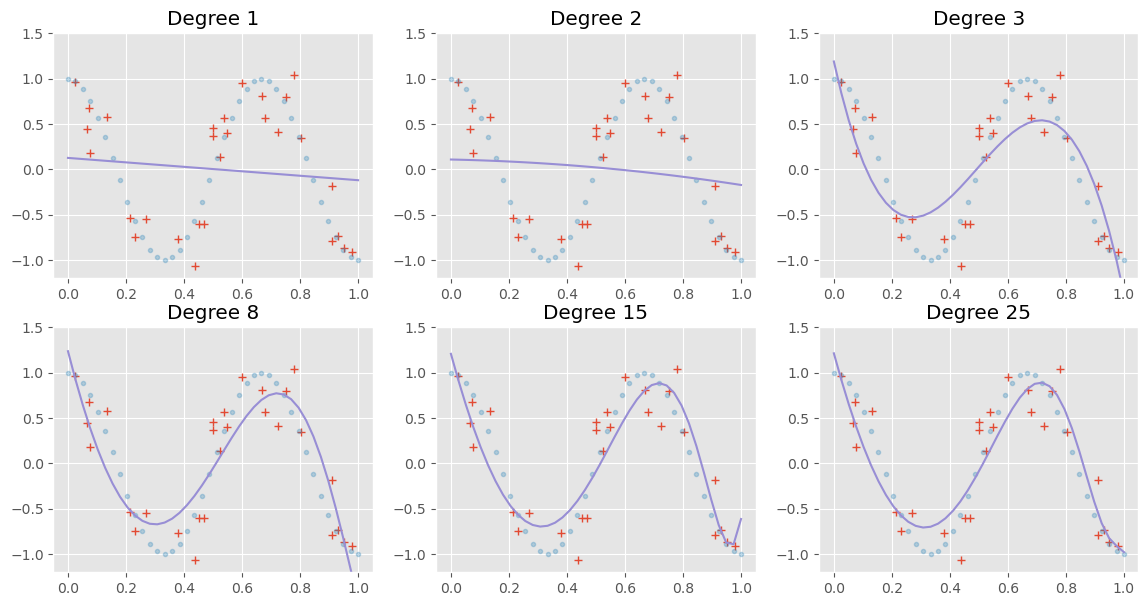

In [20]:
fig = plt.figure(figsize=(14,7))

for f, i in enumerate([1,2,3,8,15,25]):
    ax = fig.add_subplot(2,3,f+1)
    ax.plot(sample.input, sample.target, '+')
    ax.plot(np.linspace(0, 1,num=40), feval(np.linspace(0, 1,num=40)), '.', alpha=0.3);
    ax.plot(np.linspace(0, 1,num=40), model[i-1].predict(np.vander(np.linspace(0, 1,num=40), i+1, increasing=True)));
    plt.ylim(-1.2,1.5)
    plt.title(f'Degree {i}')
0;

### Plot training/validation error curves, as fn. of degree

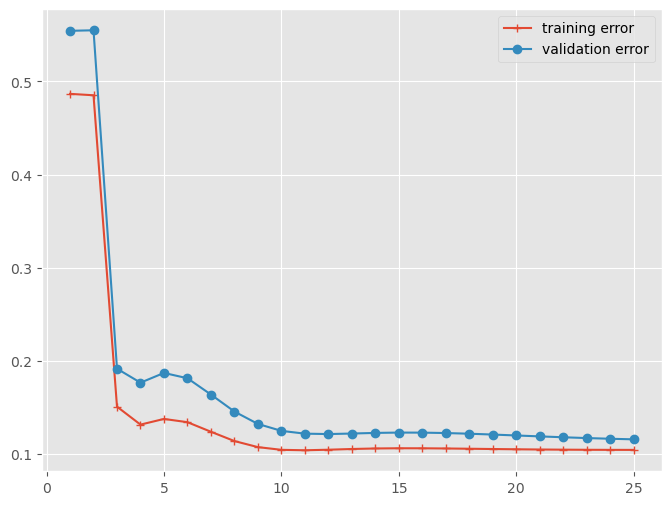

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
maxdeg = 25
plt.plot(range(1, maxdeg+1), norm_mse_train[0:maxdeg], '-+', label='training error')
plt.plot(range(1, maxdeg+1), norm_mse_valid[0:maxdeg], '-o', label='validation error')
plt.legend();

Now the coefficients are smaller due to the regularization, now we do not need logarithmic scale to represent them

### Plot coefficients' average magnitudes

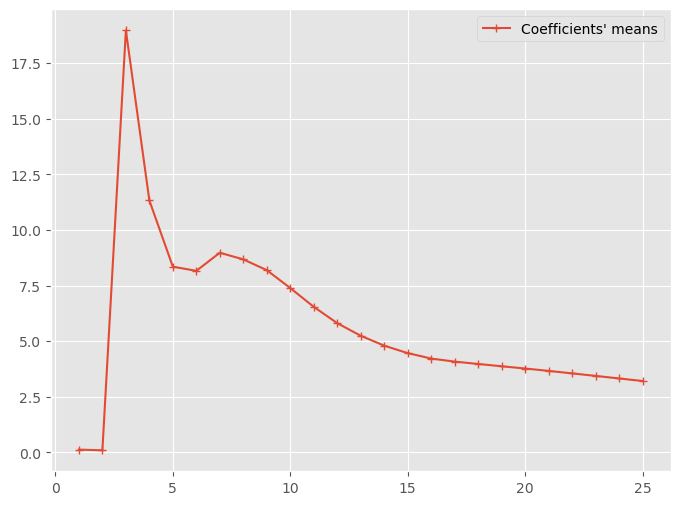

In [22]:
means = [np.mean(np.abs(m.coef_)) for m in model]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1, maxdeg+1), means[0:maxdeg], '-+', label="Coefficients' means")
plt.legend();

## Exercise

1. Play with the script and see what changes you observe; you can modify things like:

  *   Dimensions of _training_ and _validation_ sets
  *   Alter data generating function, e.g.
      * underlying function (different from _cosine_)
      * noise added to samples (different from _gaussian_)
      * non-uniform sampling of "x"
  
2. See what happens with regions of under and overfitting as you change the size of the training set 

In [53]:
def feval(x):
    return np.cos(3*np.pi*x)*np.sin(2*np.pi*x)*5

def fgen(N, sigma):
    x = np.sort(uniform(0, 1, N))
    t = feval(x) + normal(loc=0, scale=sigma, size=N)  
    return x,t

N = 10
sigma = 0.25

x,t = fgen(N, sigma)
sample = pd.DataFrame({'input':x,'target':t})

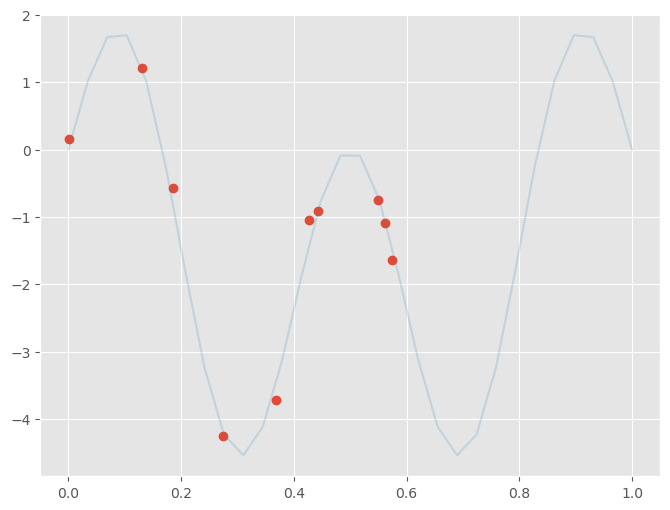

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(sample.input, sample.target, 'o')
ax.plot(np.linspace(0, 1, num=30), feval(np.linspace(0, 1,num=30)), alpha=0.2);

In [55]:
p = 1
q = 26

coef = []
model = []
norm_mse_train = []
norm_mse_valid = []


rlambda = np.linspace(0.001, 0.5, num=50)    # these are the values that we will try for regularization parameter lambda

for i in range(p,q):
    cmodel = RidgeCV(alphas=rlambda, scoring=make_scorer(mean_squared_error, greater_is_better=False))
    cmodel.fit(np.vander(sample.input,i+1, increasing=True), sample.target)
    coef.append(cmodel.coef_)

    predictions = cmodel.predict(np.vander(sample.input, i+1, increasing=True))
    norm_mse_train.append(mean_squared_error(predictions, sample.target))
    
    pred_val = cmodel.predict(np.vander(valid_sample.input, i+1, increasing=True))  
    norm_mse_valid.append(mean_squared_error(pred_val, valid_sample.target))
    
    model.append(cmodel)
0;

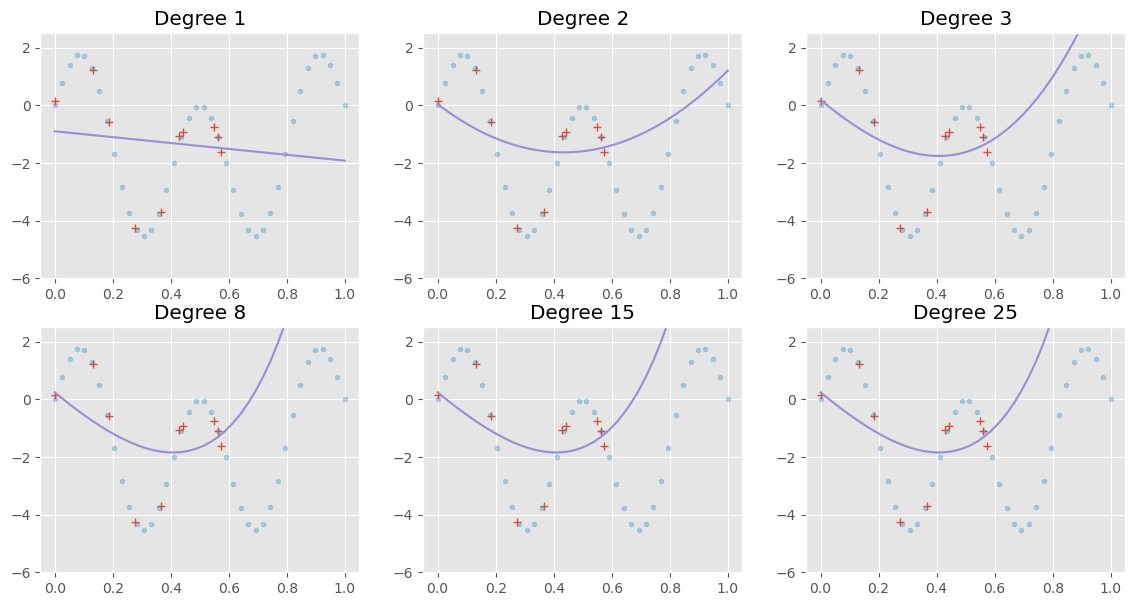

In [56]:
fig = plt.figure(figsize=(14,7))

for f, i in enumerate([1,2,3,8,15,25]):
    ax = fig.add_subplot(2,3,f+1)
    ax.plot(sample.input, sample.target, '+')
    ax.plot(np.linspace(0, 1,num=40), feval(np.linspace(0, 1,num=40)), '.', alpha=0.3);
    ax.plot(np.linspace(0, 1,num=40), model[i-1].predict(np.vander(np.linspace(0, 1,num=40), i+1, increasing=True)));
    plt.ylim(-6,2.5)
    plt.title(f'Degree {i}')
0;

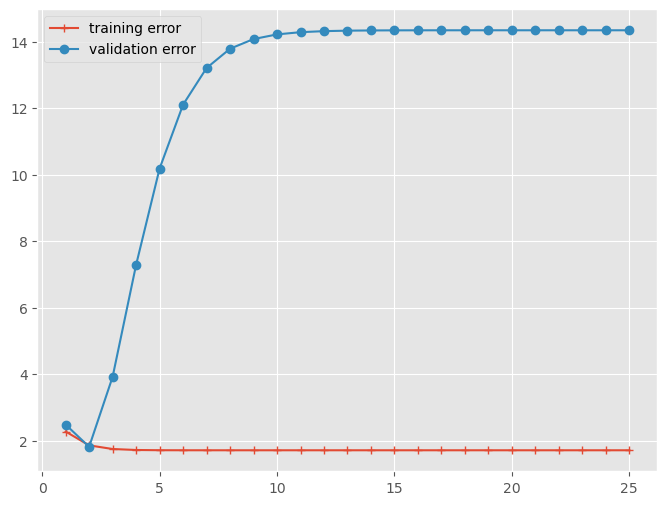

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
maxdeg = 25
plt.plot(range(1, maxdeg+1), norm_mse_train[0:maxdeg], '-+', label='training error')
plt.plot(range(1, maxdeg+1), norm_mse_valid[0:maxdeg], '-o', label='validation error')
plt.legend();

Now with bigger dataset...

In [72]:
N = 10000
sigma = 0.25

x,t = fgen(N, sigma)
sample = pd.DataFrame({'input':x,'target':t})

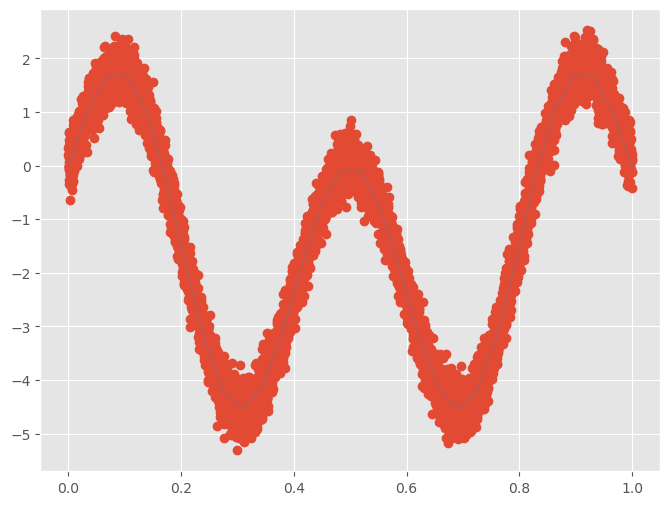

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(sample.input, sample.target, 'o')
ax.plot(np.linspace(0, 1, num=30), feval(np.linspace(0, 1,num=30)), alpha=0.2);

In [74]:
p = 1
q = 40

coef = []
model = []
norm_mse_train = []
norm_mse_valid = []


rlambda = np.linspace(0.001, 0.5, num=50)    # these are the values that we will try for regularization parameter lambda

for i in range(p,q):
    cmodel = RidgeCV(alphas=rlambda, scoring=make_scorer(mean_squared_error, greater_is_better=False))
    cmodel.fit(np.vander(sample.input,i+1, increasing=True), sample.target)
    coef.append(cmodel.coef_)

    predictions = cmodel.predict(np.vander(sample.input, i+1, increasing=True))
    norm_mse_train.append(mean_squared_error(predictions, sample.target))
    
    pred_val = cmodel.predict(np.vander(valid_sample.input, i+1, increasing=True))  
    norm_mse_valid.append(mean_squared_error(pred_val, valid_sample.target))
    
    model.append(cmodel)
0;

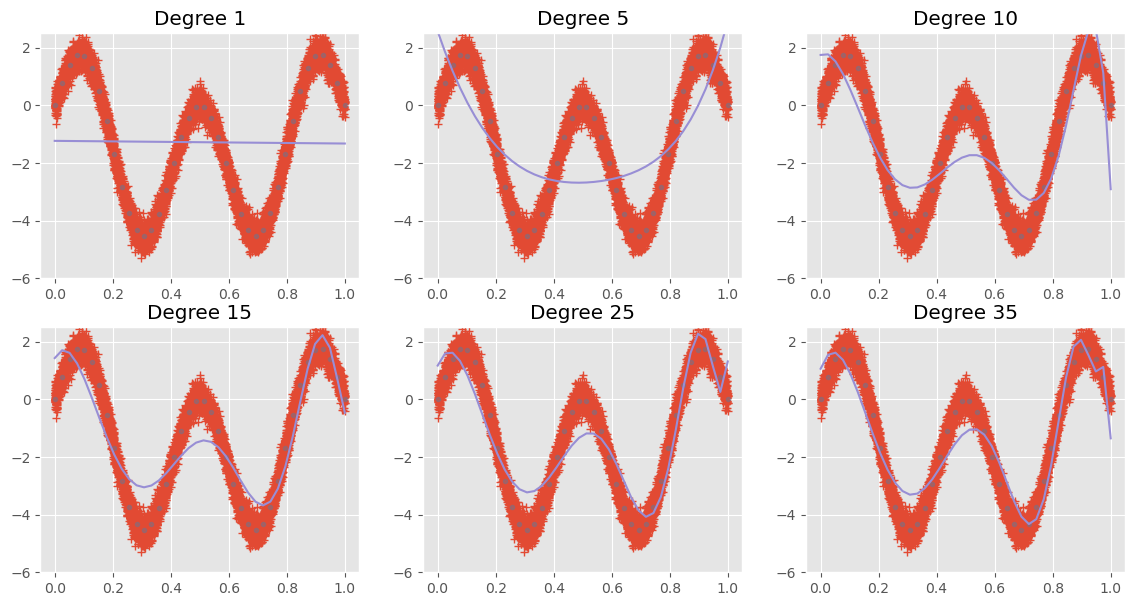

In [75]:
fig = plt.figure(figsize=(14,7))

for f, i in enumerate([1,5,10,15,25,35]):
    ax = fig.add_subplot(2,3,f+1)
    ax.plot(sample.input, sample.target, '+')
    ax.plot(np.linspace(0, 1,num=40), feval(np.linspace(0, 1,num=40)), '.', alpha=0.3);
    ax.plot(np.linspace(0, 1,num=40), model[i-1].predict(np.vander(np.linspace(0, 1,num=40), i+1, increasing=True)));
    plt.ylim(-6,2.5)
    plt.title(f'Degree {i}')
0;

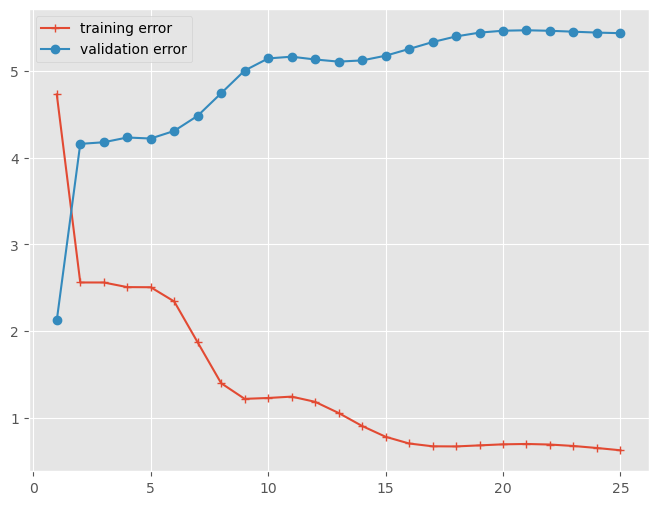

In [76]:
fig, ax = plt.subplots(figsize=(8,6))
maxdeg = 25
plt.plot(range(1, maxdeg+1), norm_mse_train[0:maxdeg], '-+', label='training error')
plt.plot(range(1, maxdeg+1), norm_mse_valid[0:maxdeg], '-o', label='validation error')
plt.legend();